# Neural Networks For Time series Forecasting
## PhD, Mackenson Polché. Analyst.

### IMPORTING LIBRARIES

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import pandas as pd

# Multiple Parallel Series

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

We may want to predict the value for each of the three time series for the next time step.

This might be referred to as multivariate forecasting.

## Synthethic data

In [2]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90,100])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95,105])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

For example:

In [3]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185],
       [100, 105, 205]])

Again, the data must be split into input/output samples in order to train a model.

Input (x):

In [4]:
dataset[:3, :]

array([[10, 15, 25],
       [20, 25, 45],
       [30, 35, 65]])

Output (y):

In [5]:
dataset[3, :]

array([40, 45, 85])

We need to re-define the `split_function()` to process our data to predict $y = f(x(t))$.

The `split_sequences()` function will split multiple parallel time series with rows for time steps and one series per column into the required input/output shape.

In [6]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
        
		# find the end of this pattern
		end_ix = i + n_steps
		
        # check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		
        # gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Choose a number of time steps.

In [7]:
n_steps = 3
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(7, 3, 3) (7, 3)


The shape of X is three-dimensional, including the number of samples (6), the number of time steps chosen per sample (3), and the number of parallel time series or features (3).

The shape of y is two-dimensional as we might expect for the number of samples (6) and the number of time variables per sample to be predicted (3).

The data is ready to use in an LSTM model that expects three-dimensional input and two-dimensional output shapes for the X and y components of each sample.

In [8]:
# summarize the data
for i in range(len(X)):
	print(f"x: {X[i]}, y: {y[i]}")

x: [[10 15 25]
 [20 25 45]
 [30 35 65]], y: [40 45 85]
x: [[20 25 45]
 [30 35 65]
 [40 45 85]], y: [ 50  55 105]
x: [[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]], y: [ 60  65 125]
x: [[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]], y: [ 70  75 145]
x: [[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]], y: [ 80  85 165]
x: [[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]], y: [ 90  95 185]
x: [[ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]], y: [100 105 205]


We will use a Vanilla (simple) LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument. The number of parallel series is also used in the specification of the number of values to predict by the model in the output layer; again, this is three.

## Model

In [9]:
n_features = X.shape[2]
n_features

3

In [10]:
model = Sequential()
model.add(LSTM(100, activation = "relu", return_sequences = False, input_shape = (n_steps, n_features)))
model.add(Dense(n_features))

model.compile(optimizer = "adam", loss = "mse")

The shape of the input for making a single prediction must be 1 sample, 3 time steps, and 3 features, or [1, 3, 3]

In [11]:
model.fit(X, y, epochs = 300, verbose = 0)

Prediction on a new value.

In [12]:
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 99.983055 105.008865 205.03896 ]]


# Multiple Parallel Series for a more complex example

## Synthetic data

In [13]:
raw_seq_base = np.array(range(1, 300, 3))
raw_seq_base[:5]

array([ 1,  4,  7, 10, 13])

In [14]:
np.random.seed(1)

noise = np.random.normal(0, 2, len(raw_seq_base))/10

raw_seq0 = [np.sin(x/10)*np.exp(-x/200) + 2 for x in raw_seq_base] 
raw_seq0 = np.array(raw_seq0) + noise

raw_seq1 = [0.5*np.cos(x/10)*np.exp(x/200) + 3 for x in raw_seq_base] 
raw_seq1 = np.array(raw_seq1) + noise

raw_seq2 = [2*np.sin(x/10-0.75)*np.exp(-x/100) + 2 for x in raw_seq_base] 
raw_seq2 = np.array(raw_seq2) + noise


In [15]:
raw_seq0.shape

(100,)

In [16]:
#raw_seq0 = np.exp(raw_seq0)
raw_seq = np.vstack((raw_seq0, raw_seq1, raw_seq2))
print(raw_seq.shape)

(3, 100)


In [17]:
raw_seq = np.transpose(raw_seq)
print(raw_seq.shape)

(100, 3)


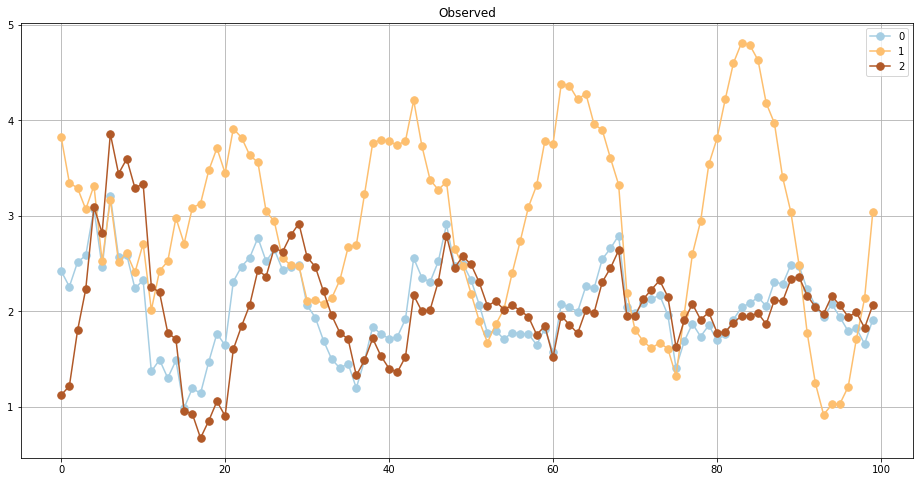

In [18]:
colormap = "Paired"

pd.DataFrame(raw_seq).plot(figsize = (16, 8), title = "Observed", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

In [19]:
raw_seq[:3]

array([[2.42420457, 3.82486489, 1.12653967],
       [2.25935606, 3.34748255, 1.21874353],
       [2.51642574, 3.29040847, 1.80116511]])

In [20]:
n_steps = 5
X, y = split_sequences(raw_seq, n_steps)
print(X.shape, y.shape)

(95, 5, 3) (95, 3)


In [21]:
print(f"x: {X[0]}, y: {y[0]}")

x: [[2.42420457 3.82486489 1.12653967]
 [2.25935606 3.34748255 1.21874353]
 [2.51642574 3.29040847 1.80116511]
 [2.58583824 3.06940837 2.23312699]
 [3.07600055 3.31581342 3.09102006]], y: [2.46241499 2.52387653 2.82009012]


## Model

In [22]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(500, activation = "relu", return_sequences = False, input_shape = (n_steps, n_features)))
model.add(Dense(n_features))

model.compile(optimizer = "adam", loss = "mse")

model.fit(X, y, epochs = 500, verbose = 0)

## Plot predictions

In [23]:
prediction = model.predict(X)
prediction[:3]

3/3 [==============================] - 1s 24ms/step


array([[2.8217535, 2.7704966, 2.995208 ],
       [3.0473108, 3.0306294, 3.678786 ],
       [2.799745 , 2.6101325, 3.5325792]], dtype=float32)

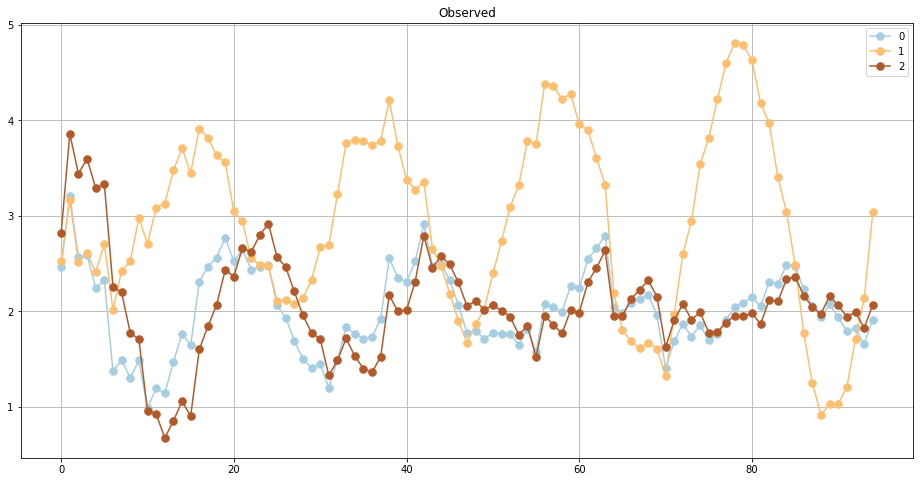

In [24]:
pd.DataFrame(y).plot(figsize = (16, 8), title = "Observed", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

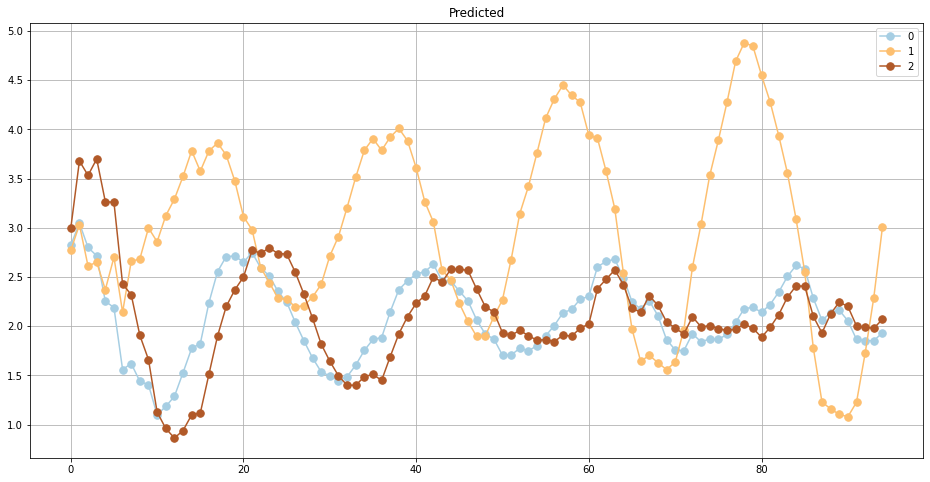

In [25]:
pd.DataFrame(prediction).plot(figsize = (16, 8), title = "Predicted", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

### Zoom in

In [26]:
last_n = 20

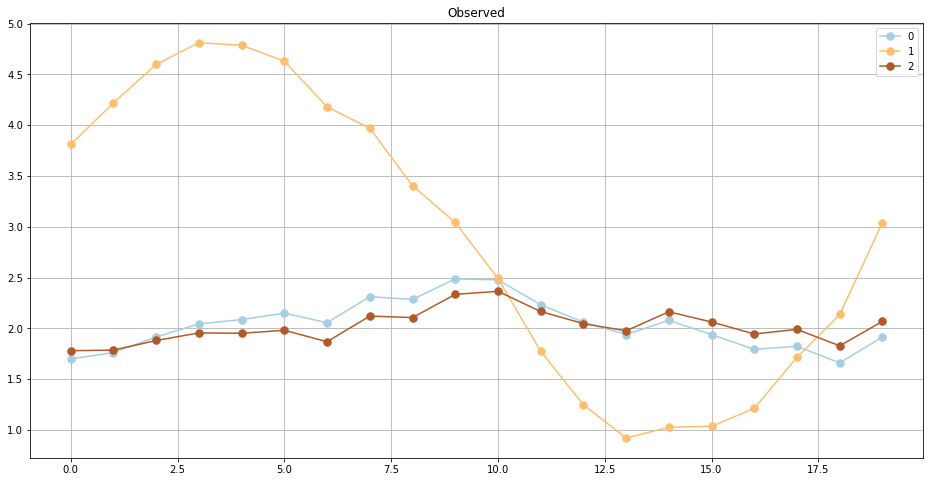

In [27]:
pd.DataFrame(y[-last_n:, :]).plot(figsize = (16, 8), title = "Observed", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

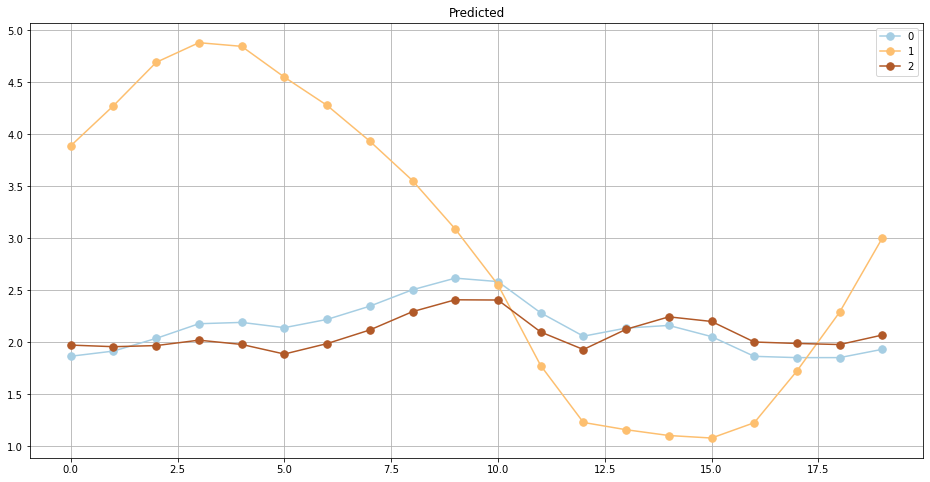

In [28]:
pd.DataFrame(prediction[-last_n:, :]).plot(figsize = (16, 8), title = "Predicted", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

### Plot the differences between the truth and the predicted

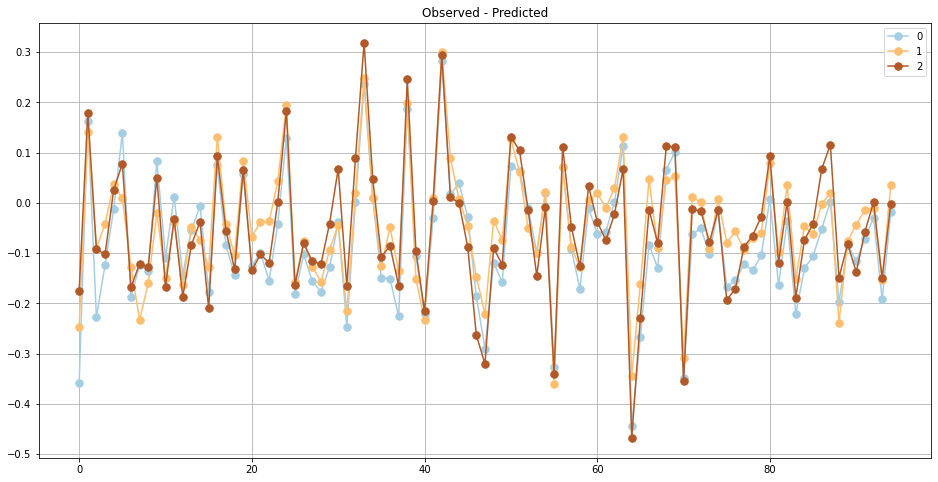

In [29]:
pd.DataFrame(y-prediction).plot(figsize = (16, 8), title = "Observed - Predicted", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

## Predictions on new data

### For a single new value

In [30]:
y_new_0 = y[-n_steps:]
y_new_0.shape

(5, 3)

In [31]:
X[-2:].shape

(2, 5, 3)

In [32]:
pred = model.predict(y_new_0.reshape(1, n_steps, n_features))
pred.shape

1/1 [==============================] - 0s 95ms/step


(1, 3)

In [33]:
pred

array([[2.0395947, 3.7756932, 2.1948462]], dtype=float32)

In [34]:
y_new = (y[-n_steps:])
print((y_new).shape, type(y_new)) 

(5, 3) <class 'numpy.ndarray'>


### For _n_ steps in the future

In [35]:
n_steps_fut = 10

y_new = (y[-n_steps:])

for i in range(n_steps_fut):
    
    y_new_test = y_new[-n_steps:]
    y_new_test = np.array(y_new_test).reshape(1, n_steps, n_features)
    
    y_fut_step = model.predict(y_new_test, verbose = 0)
    
    y_new = np.concatenate((y_new, y_fut_step), axis = 0)    

In [36]:
y_new.shape

(15, 3)

In [37]:
y_All = np.concatenate((y[:-n_steps], y_new))
y_All.shape

(105, 3)

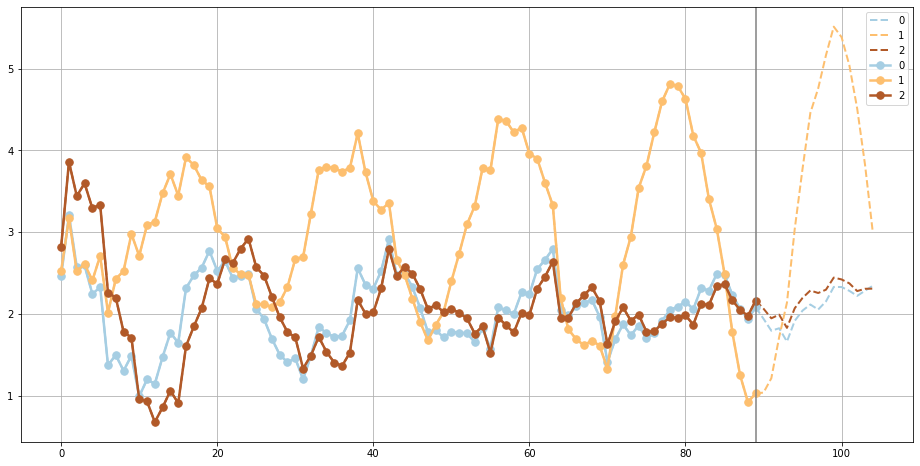

In [38]:
ax = pd.DataFrame(y_All).plot(style = "--", lw = 2, figsize = (16, 8), colormap = colormap)
pd.DataFrame(y[:-n_steps]).plot(style = ".-", markersize = 15, lw = 2.5, ax = ax, colormap = colormap)
plt.grid()
plt.axvline(x = y.shape[0] - n_steps - 1, color = "gray")

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500)               1008000   
                                                                 
 dense_1 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 1,009,503
Trainable params: 1,009,503
Non-trainable params: 0
_________________________________________________________________


# Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting.

Specifically, these are problems where the forecast horizon or interval is more than one time step.

In [40]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
raw_seq

[10, 20, 30, 40, 50, 60, 70, 80, 90]

The `split_sequence()` implementes the desired behavior adn will split a given univariate time series into samples with a specified number of input and output time steps.

In [41]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		
        # find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		
        # check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		
        # gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [42]:
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

In [43]:
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5, 3) (5, 2)


In [44]:
# summarize the data
for i in range(len(X)):
	print(f"x: {X[i]}, y: {y[i]}")

x: [10 20 30], y: [40 50]
x: [20 30 40], y: [50 60]
x: [30 40 50], y: [60 70]
x: [40 50 60], y: [70 80]
x: [50 60 70], y: [80 90]


We need to prepare the data as tensors of order 3. 

In [45]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(5, 3, 1)

We use a Vanilla (simple) LSTM forecasting model.

In [46]:
model = Sequential()
model.add(LSTM(100, activation = "relu", return_sequences = False, input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))

model.compile(optimizer = "adam", loss = "mse")

The shape of the input for making a single prediction must be 1 sample, 3 time steps, and 3 features, or [1, 3, 3]

In [47]:
model.fit(X, y, epochs = 100, verbose = 0)

Prediction on a new observation.

In [48]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
yhat

array([[101.486626, 121.033   ]], dtype=float32)

# Multi-Step LSTM Models for a more complex example

## Synthethic data

In [49]:
raw_seq0 = np.array(range(1, 300, 3))
print(np.min(raw_seq0), np.max(raw_seq0))

1 298


In [50]:
raw_seq0 = [np.sin(x/10)*np.exp(-x/200) + 1 for x in raw_seq0]
raw_seq0[:10]

[1.0993354954040364,
 1.381707342492255,
 1.6220600880456373,
 1.8004319606128645,
 1.9029190246254228,
 1.9227227323841996,
 1.8605396876278488,
 1.7242786768060752,
 1.5281498134549032,
 1.291224707099048]

In [51]:
#raw_seq0 = np.exp(raw_seq0)
np.random.seed(1)
raw_seq = raw_seq0 + np.random.normal(0, 2, len(raw_seq0))/10
raw_seq[:3]

array([1.42420457, 1.25935606, 1.51642574])

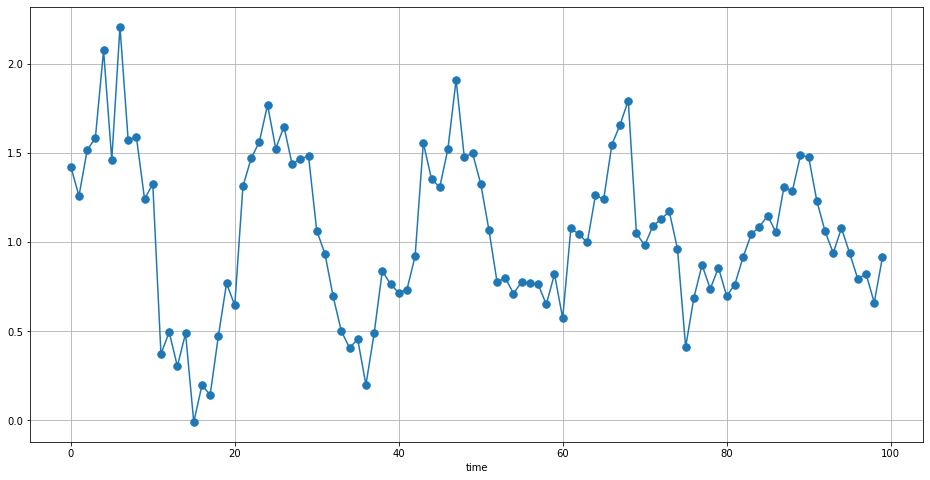

In [52]:
plt.figure(figsize = (16, 8))
plt.plot(raw_seq, ".-", markersize = 15)
plt.xlabel("time")
plt.grid()

In [53]:
# choose a number of time steps
n_steps_in = 3
n_steps_out = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(95, 3) (95, 3)


In [54]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(95, 3, 1)

## Model

In [55]:
model = Sequential()
model.add(LSTM(500, activation = "relu", return_sequences = False, input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer = "adam", loss = "mse")
# fit model
model.fit(X, y, epochs = 500, verbose = 0)

## Plot predictions

In [56]:
prediction = model.predict(X)
prediction[:3]

3/3 [==============================] - 0s 16ms/step


array([[1.3345351, 1.3410616, 1.1887587],
       [1.5736434, 1.4368058, 1.4451334],
       [1.8065875, 1.7511888, 1.5627078]], dtype=float32)

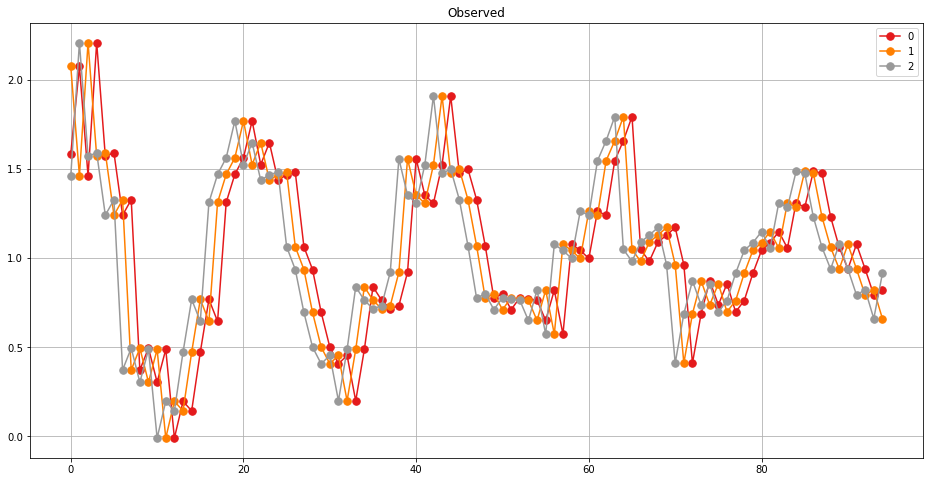

In [57]:
colormap = "Set1"

pd.DataFrame(y).plot(figsize = (16, 8), title = "Observed", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

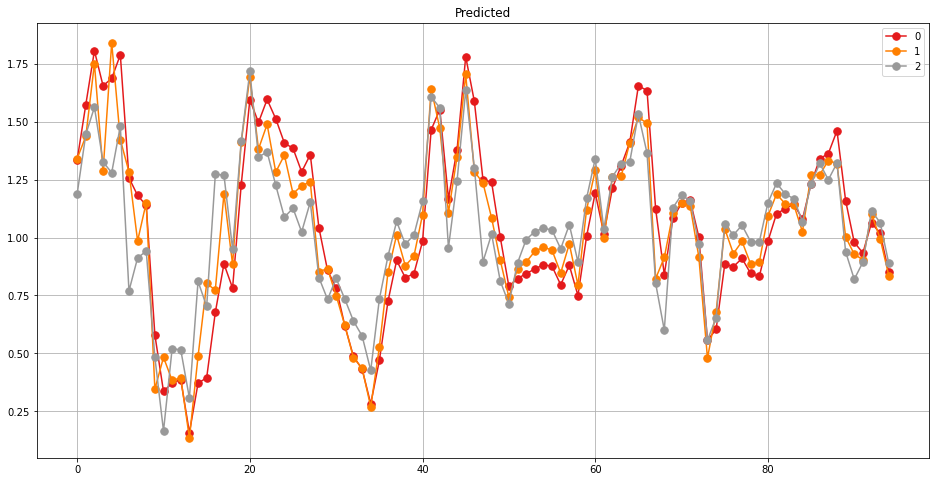

In [58]:
pd.DataFrame(prediction).plot(figsize = (16, 8), title = "Predicted", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

### Zoom in

In [59]:
last_n = 20

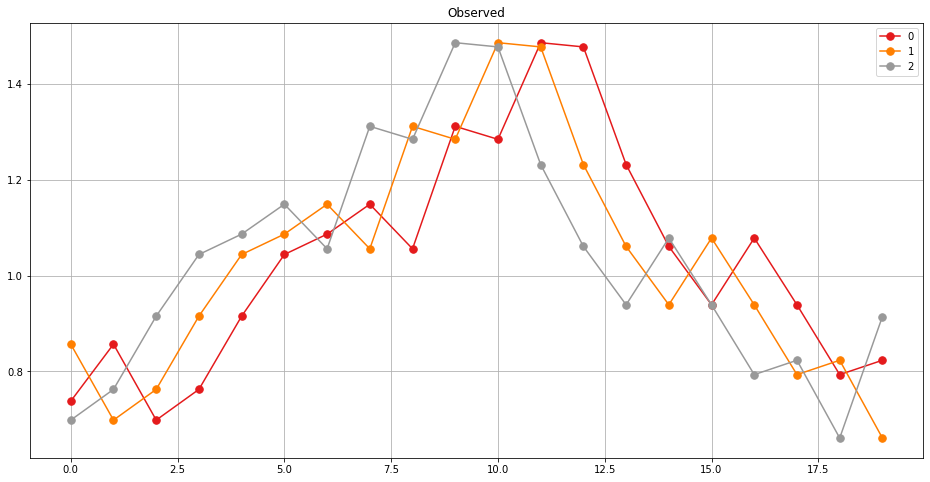

In [60]:
pd.DataFrame(y[-last_n:, :]).plot(figsize = (16, 8), title = "Observed", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

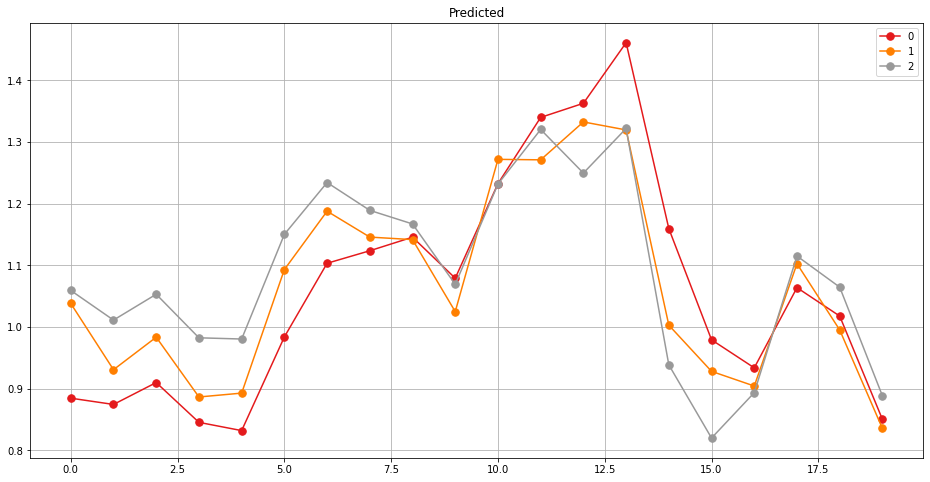

In [61]:
pd.DataFrame(prediction[-last_n:, :]).plot(figsize = (16, 8), title = "Predicted", style = ".-", markersize = 15, colormap = colormap)
plt.grid()

### Plot the differences between the truth and the predicted

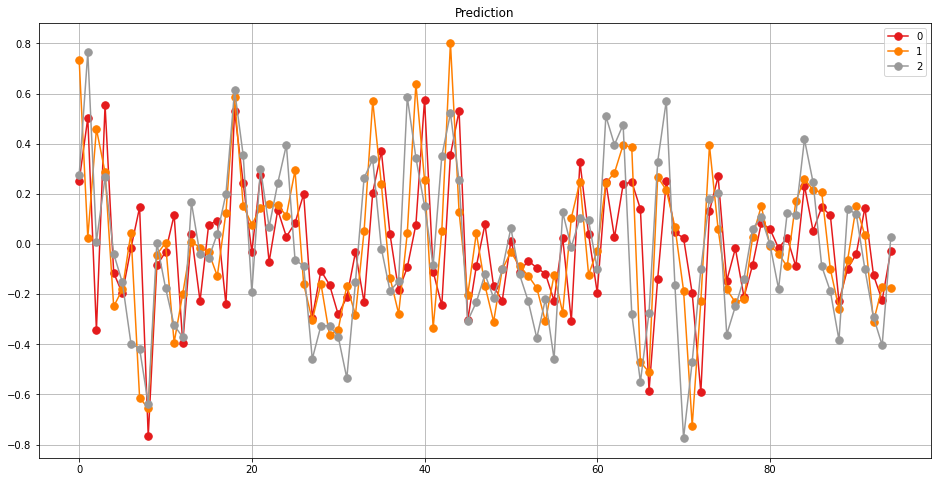

In [74]:

pd.DataFrame(y-prediction).plot(figsize = (16, 8), title = "Prediction", style = ".-", markersize = 15, colormap = colormap)
plt.grid()
